In [238]:
import cv2
import imutils
import math
from math import atan2

import matplotlib
import numpy as np
from numpy import trapz
import pandas as pd
import seaborn as sns
import typing as tp

from scipy import spatial

from matplotlib import pyplot as plt

sns.set()
sns.set_style("whitegrid")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [343]:
class Video():
    
    
   
    
    def __init__(self, path, start=0, stop=math.inf) -> None:
        """
        Сохраняет (во внутреннюю переменную) последовательность масштабированных кадров с настроенной яркостью.
        Видео обрезается согласно номерам кадров start и stop при их указании.
        """
        def preprocessing(img, value=100):
            crop_img = img[0:img.shape[0], 
                           int((img.shape[1] - img.shape[0])/2):int((img.shape[1] - img.shape[0])/2 + img.shape[0])]
            out = cv2.convertScaleAbs(crop_img, alpha=1.3, beta=-150)
            return cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
        
        self.metric_const = 91
        self.frames = []
        vidcap = cv2.VideoCapture(path)
        success,image = vidcap.read()
        current_frame = 0
        begin = 0
        while success:
            if (stop >= current_frame >= start):
                if (np.sum(image)/(1023 * image.shape[0] * image.shape[1]) < 0.37 and begin == 1):
                    self.frames.append(preprocessing(image))
                elif (np.sum(image)/(1023 * image.shape[0] * image.shape[1]) >= 0.37 and begin == 0):
                    begin = 1
            success,image = vidcap.read()
            current_frame += 1
         
        
    def calculate(self, find_triangles: bool = False) -> None:
        """
        Сохраняет траектории роботов, а также изменения углов поворота относительно первоначального положения.
        find_triangles: необходимо ли искать углы.
        Полученные значения масштабируются в соответствии с real_radius в сантиметрах.
        """
        def euclidian_distance(vertex_0: np.ndarray, vertex_1: np.ndarray):
            return ((vertex_0[0] - vertex_1[0])**2 + (vertex_0[1] - vertex_1[1])**2)**0.5
        
        def control_vertex(vertex_0, vertex_1, vertex_2):
            rho_1 =  euclidian_distance(vertex_0, vertex_1)
            rho_2 =  euclidian_distance(vertex_1, vertex_2)
            rho_3 =  euclidian_distance(vertex_0, vertex_2)

            if (rho_1 < rho_2 and rho_1 < rho_3):
                return (2, 0, 1)
            elif (rho_2 < rho_1 and rho_2 < rho_3):
                return (0, 1 , 2)
            else:
                return (1, 0 , 2)
            
            
        def convert_to_triangle(vertexes: np.ndarray):
            min = [10005000, 0, 0]
            for i in range (0, len(vertexes)):
                for j in range (i+1, len(vertexes)):
                    if euclidian_distance(vertexes[i][0], vertexes[j][0]) < min[0]:
                        min = [euclidian_distance(vertexes[i][0], vertexes[j][0]), i, j]
            return np.delete(vertexes,  min[2], 0)
            
    
        def get_triangles(frame: np.ndarray, index: int):
            """
            Ищет треугольник на кадре
            """
            thresh = cv2.threshold(frame, 130, 255, cv2.THRESH_TOZERO)[1]
            (contours, _) = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            self.shapes.append([]);
            number_of_triangle = 0
            for i in range (0, len(contours)):
                if len(cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)) == 3:
                    if 3500 >= cv2.contourArea(contours[i]) >= 1000:
                        self.shapes[index].append([contours[i], cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], 
                                        True), True)])
                        vertexes = control_vertex(self.shapes[index][number_of_triangle][1][0][0], 
                                        self.shapes[index][number_of_triangle][1][1][0], 
                                        self.shapes[index][number_of_triangle][1][2][0])
                        center = (int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][0] + 
                                        self.shapes[index][number_of_triangle][1][vertexes[2]][0][0])/2), 
                                  int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][1] + 
                                        self.shapes[index][number_of_triangle][1][vertexes[2]][0][1])/2))
                        self.shapes[index][number_of_triangle].append(center)
                       
                        
                        if (find_triangles == True):
                            angle = atan2(self.shapes[index][number_of_triangle][1][vertexes[0]][0][0] - center[0], 
                                        self.shapes[index][number_of_triangle][1][vertexes[0]][0][1] - center[1])
                            if (angle < 0):
                                angle = 2*3.14 + angle
                            self.shapes[index][number_of_triangle].append(angle)
                            
                        number_of_triangle += 1
                        
            
            
            if len(self.shapes[index]) < 3:
                for i in range (0, len(contours)):
                    if len(cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)) == 4:
                        if 3500 >= cv2.contourArea(contours[i]) >= 1000:
                            self.shapes[index].append([contours[i], cv2.approxPolyDP(contours[i], 0.04 * 
                                                                               cv2.arcLength(contours[i], True), True)])
                            self.shapes[index][number_of_triangle][1] = convert_to_triangle(self.shapes[index][number_of_triangle][1])

                            vertexes = control_vertex(self.shapes[index][number_of_triangle][1][0][0], 
                                                      self.shapes[index][number_of_triangle][1][1][0], 
                                                      self.shapes[index][number_of_triangle][1][2][0])
                            center = (int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][0] + self.shapes[index][number_of_triangle][1][vertexes[2]][0][0])/2), 
                                  int((self.shapes[index][number_of_triangle][1][vertexes[1]][0][1] + self.shapes[index][number_of_triangle][1][vertexes[2]][0][1])/2))
                            self.shapes[index][number_of_triangle].append(center)
                            
                            
                            if (find_triangles == True):
                                angle = atan2(self.shapes[index][number_of_triangle][1][vertexes[0]][0][0] - center[0], 
                                          self.shapes[index][number_of_triangle][1][vertexes[0]][0][1] - center[1])
                                if (angle < 0):
                                    angle = 2*3.14 + angle
                                self.shapes[index][number_of_triangle].append(angle)
            
                            number_of_triangle += 1
            
            
            self.indicator.append([index, len(self.shapes[index])])
        
        def find_next_position(shape: np.ndarray, layer: np.ndarray):
            
            """
            Ищет следующее положение робота.
            """
            min = [100500, 0, 0, 0]
            for j in range (0, len(layer)):
                if (euclidian_distance(shape,layer[j][2]) < min[0]):
                    min = [euclidian_distance(shape,layer[j][2]), j, layer[j][2], layer[j][3]]
            return min
        
        
        self.shapes = []
        self.indicator = []
        for index in range (0, len(self.frames)):
            get_triangles(self.frames[index], index)
        
        
        
#        for index in range (0, len(self.frames)):
#            for c in range (0, len(self.shapes[index])):
#                cv2.drawContours(self.frames[index], self.shapes[index][c], 0, (255,128,0),3)
#                cv2.circle(self.frames[index], self.shapes[index][c][2], 5, (255,128,0), 3)
        
        self.trace = []
        
        for c in range (0, len(self.shapes[index])):
            self.trace.append([]);
            self.trace[c].append([0, self.shapes[0][c][2], self.shapes[0][c][3]])
            number = c
            distance = 0
            for index in range (0, len(self.frames)-1): 
                next_condition = find_next_position(self.shapes[index][number][2], self.shapes[index+1])
                number = next_condition[1]
                distance += next_condition[0]
                self.trace[c].append([distance/self.metric_const, next_condition[2], next_condition[3]*57.32])
        self.t = range(0, len(video.trace[0]))
        self.t = [x / 24 for x in self.t]
    
        
        for c in range (0, len(self.trace)):
            for index in range (0, len(self.frames)-1):
                cv2.circle(self.frames[index], self.trace[c][index][1], 5, (255,128,0), 3)
    
    def draw_frame(self, index: int) -> None:
        """
        Выводит на экран кадр с отображёнными на нём фигурами при их существовании.
        """
        plt.imshow(self.frames[index])
    
    def plot_distances(self, indices: tp.List[int] = None):
        """
        Строит траектории роботов с заданными индексами, либо всех.
        """
        ax = plt.figure(figsize = (12, 10)).gca()
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_title('Traveled distance of ' + str(len(video.trace)) + ' bots', fontsize = 28)
        ax.set_xlabel('time, s', fontsize = 28)
        ax.set_ylabel('x, сm', fontsize = 28)
        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        for c in range (0, len(video.trace)):
            plt.plot(self.t,  np.array(self.trace[c])[:, 0], label = type)
        plt.savefig("dist.svg")    
        
    def plot_trajectories(self, indices: tp.List[int] = None):
        sns.set_palette('GnBu_d')
        ax = plt.figure(figsize = (12, 10)).gca()
        ax.set_title('Trajectories of ' + str(len(video.trace)) + ' bots', fontsize = 28)
        ax.set_xlabel('y, сm', fontsize = 28)
        ax.set_ylabel('x, сm', fontsize = 28)
        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        ax.set_ylim(0, 12)
        ax.set_xlim(0, 10)
        for c in range (0, len(video.trace)):
            xx = [(i[0] - 200)/self.metric_const for i in np.array(video.trace[c])[:, 1]]
            yy = [i[1]/self.metric_const for i in np.array(video.trace[c])[:, 1]]
            plt.plot(xx, yy, label = type)
        plt.gca().add_artist(plt.Circle((4.5, 5.7), 4.6, color='gray', fill=False, linestyle='--'))
        plt.savefig("trajectories.svg")    
        
        
    def plot_median_displacement(self, indices: tp.List[int] = None):
        """
        Строит зависимость среднего расстояния от центра от времени для роботов с заданными индексами.
        """
        

        
    def plot_angles(self) -> tp.Any:
        
        for c in range (0, len(video.trace)):
            ax = plt.figure(figsize = (12, 10)).gca()
            ax.set_title('Relation between angle and time, ' + str(c) + ' bot', fontsize = 28)
            ax.set_xlabel('time, s', fontsize = 28)
            ax.set_ylabel('α,°', fontsize = 28)
            ax.tick_params(axis='x', labelsize=32)
            ax.tick_params(axis='y', labelsize=32)
            plt.plot(self.t, np.array(self.trace[c])[:, 2])
            plt.savefig("angle" + str(c) +".svg")   
            plt.show()
    
    def save_to_csv(self, path: str) -> None:
        """
        Сохраняет известную информацию в csv.
        """
        pass

In [344]:
path = 'videos_test/1.mp4'
video = Video(path, 0, 300)

In [345]:
len(video.frames)
video.calculate(True)

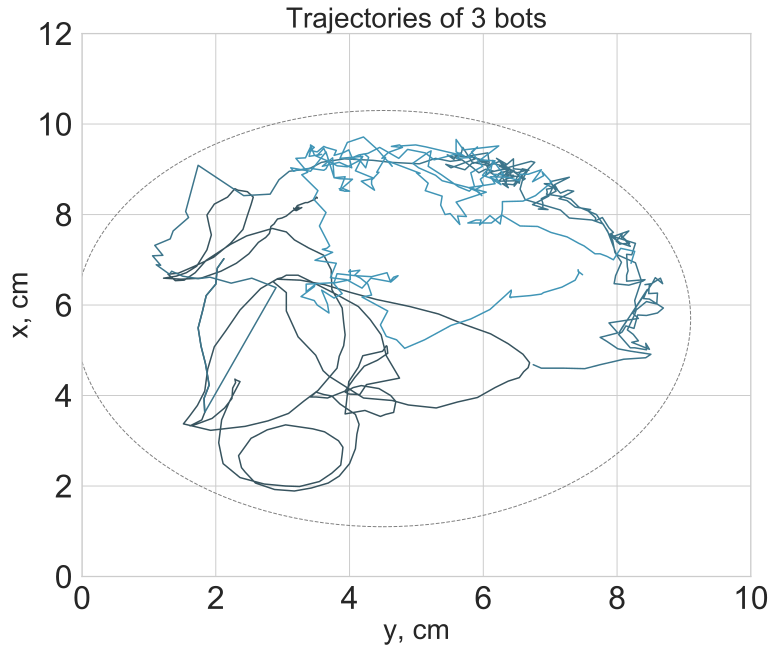

In [346]:
video.plot_trajectories()

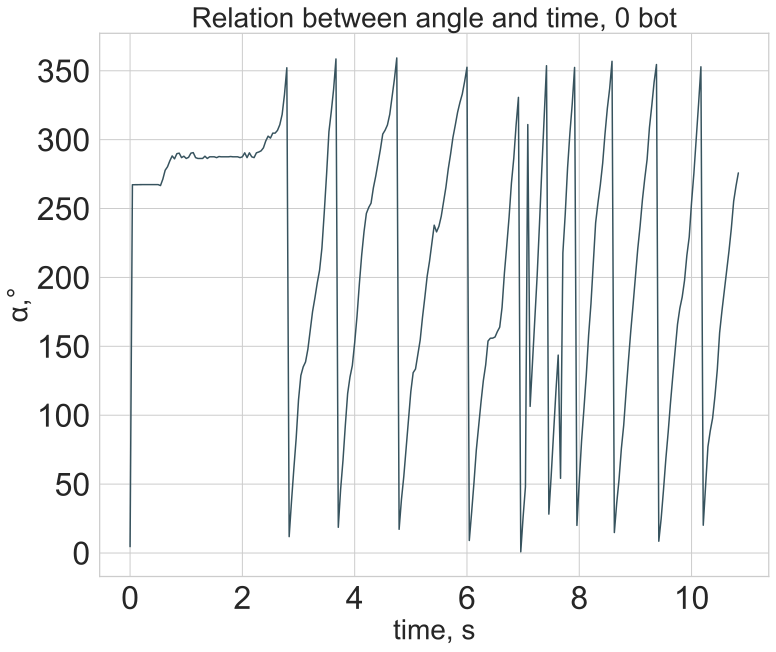

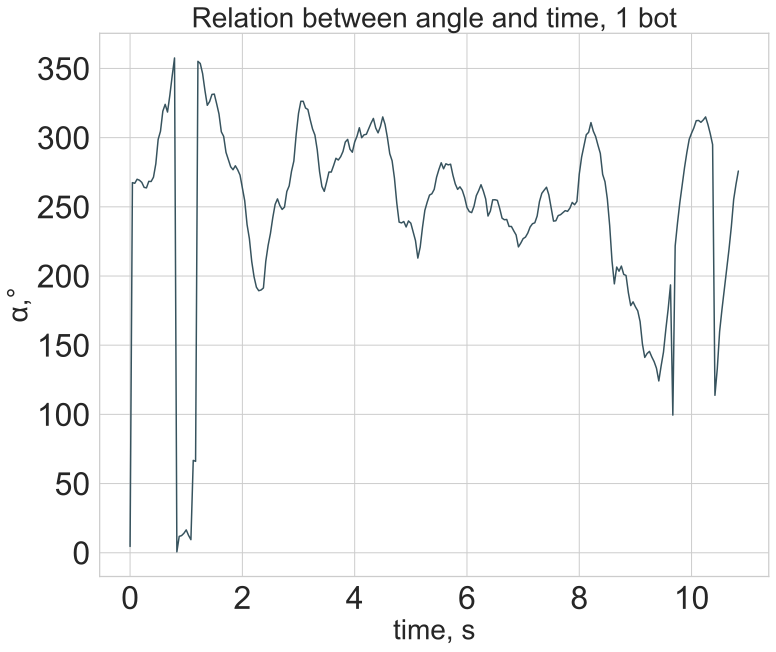

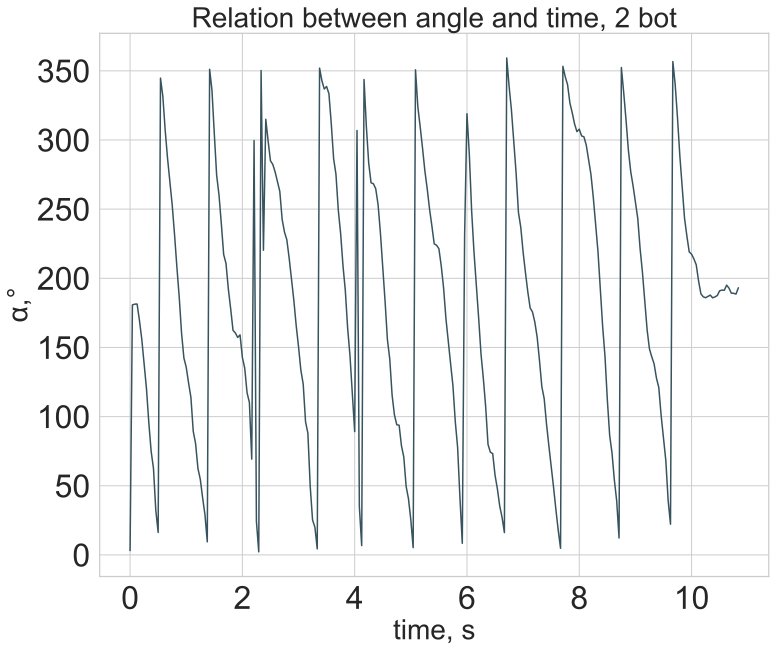

In [347]:
video.plot_angles()

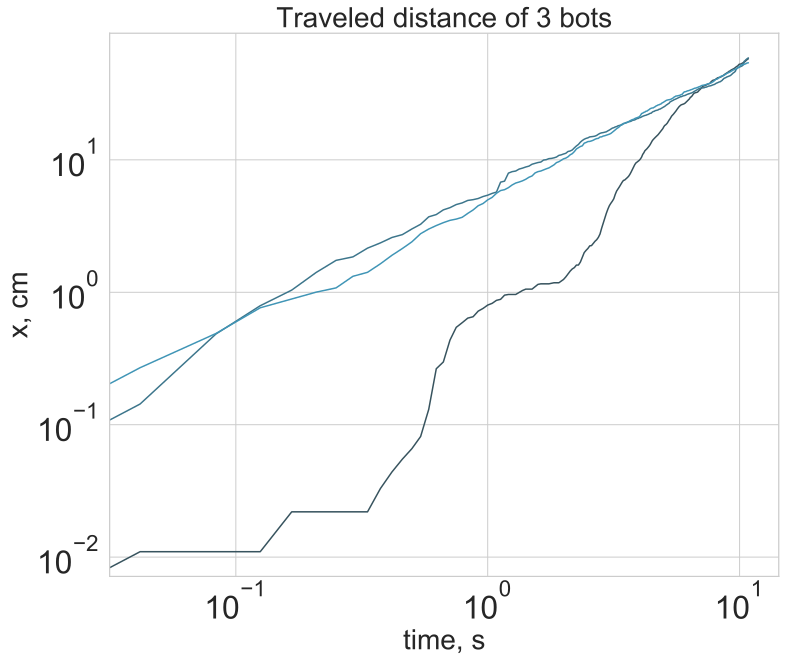

In [342]:
video.plot_distances()

In [ ]:
%debug

In [226]:
rr = np.array(video.trace[0])[:, 1]

In [229]:
[i[1] for i in np.array(video.trace[0])[:, 1]]

[763,
 762,
 762,
 762,
 762,
 762,
 762,
 762,
 762,
 761,
 762,
 761,
 762,
 763,
 759,
 752,
 752,
 746,
 737,
 741,
 737,
 736,
 742,
 739,
 743,
 741,
 737,
 736,
 742,
 743,
 743,
 743,
 740,
 743,
 742,
 742,
 742,
 741,
 742,
 742,
 742,
 742,
 742,
 742,
 742,
 742,
 742,
 743,
 742,
 737,
 743,
 737,
 742,
 743,
 737,
 737,
 742,
 736,
 725,
 721,
 719,
 711,
 710,
 704,
 696,
 690,
 682,
 672,
 649,
 630,
 614,
 600,
 598,
 600,
 604,
 611,
 624,
 657,
 687,
 706,
 727,
 749,
 763,
 780,
 777,
 774,
 763,
 748,
 726,
 698,
 670,
 642,
 624,
 610,
 608,
 595,
 596,
 611,
 636,
 668,
 685,
 700,
 693,
 677,
 661,
 646,
 617,
 577,
 540,
 511,
 486,
 464,
 443,
 419,
 400,
 374,
 353,
 328,
 313,
 302,
 294,
 307,
 322,
 344,
 373,
 417,
 462,
 495,
 536,
 579,
 598,
 596,
 587,
 571,
 557,
 543,
 528,
 507,
 488,
 468,
 447,
 430,
 420,
 412,
 400,
 393,
 380,
 360,
 351,
 339,
 345,
 354,
 359,
 403,
 414,
 445,
 482,
 534,
 571,
 593,
 599,
 601,
 606,
 606,
 593,
 569,
 543

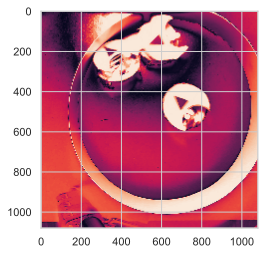

In [156]:
for c in range (0, len(video.frames)):
    plt.imshow(video.frames[c])
    plt.savefig("res/test" + str(c) + ".png")    

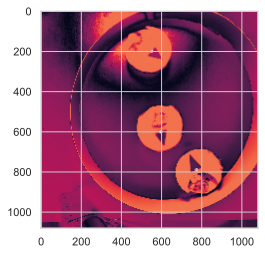

In [280]:
 plt.imshow(video.frames[209])

In [19]:
video.shapes[249]

[[array([[[773, 476]],
  
         [[774, 475]],
  
         [[776, 477]],
  
         [[776, 478]],
  
         [[778, 480]],
  
         [[778, 481]],
  
         [[779, 482]],
  
         [[779, 483]],
  
         [[780, 484]],
  
         [[780, 485]],
  
         [[781, 486]],
  
         [[781, 487]],
  
         [[782, 488]],
  
         [[782, 489]],
  
         [[783, 490]],
  
         [[783, 491]],
  
         [[784, 492]],
  
         [[784, 493]],
  
         [[785, 494]],
  
         [[785, 495]],
  
         [[786, 496]],
  
         [[786, 497]],
  
         [[787, 498]],
  
         [[787, 499]],
  
         [[788, 500]],
  
         [[788, 501]],
  
         [[789, 502]],
  
         [[789, 504]],
  
         [[790, 505]],
  
         [[790, 506]],
  
         [[791, 507]],
  
         [[791, 508]],
  
         [[792, 509]],
  
         [[792, 510]],
  
         [[794, 512]],
  
         [[794, 513]],
  
         [[796, 515]],
  
         [[796, 517]],
  
         [[7

In [20]:
video.shapes[250]

[[array([[[771, 477]],
  
         [[772, 476]],
  
         [[773, 476]],
  
         [[775, 478]],
  
         [[775, 479]],
  
         [[776, 480]],
  
         [[776, 481]],
  
         [[777, 482]],
  
         [[777, 483]],
  
         [[778, 484]],
  
         [[778, 485]],
  
         [[780, 487]],
  
         [[780, 488]],
  
         [[781, 489]],
  
         [[781, 491]],
  
         [[783, 493]],
  
         [[783, 494]],
  
         [[784, 495]],
  
         [[784, 496]],
  
         [[785, 497]],
  
         [[785, 498]],
  
         [[786, 499]],
  
         [[786, 500]],
  
         [[787, 501]],
  
         [[787, 502]],
  
         [[788, 503]],
  
         [[788, 505]],
  
         [[789, 506]],
  
         [[789, 507]],
  
         [[790, 508]],
  
         [[790, 509]],
  
         [[791, 510]],
  
         [[791, 511]],
  
         [[793, 513]],
  
         [[793, 514]],
  
         [[795, 516]],
  
         [[795, 517]],
  
         [[796, 518]],
  
         [[7

In [17]:
video.indicator

[[0, 3],
 [1, 3],
 [2, 3],
 [3, 3],
 [4, 3],
 [5, 3],
 [6, 3],
 [7, 3],
 [8, 3],
 [9, 3],
 [10, 5],
 [11, 4],
 [12, 3],
 [13, 3],
 [14, 3],
 [15, 3],
 [16, 3],
 [17, 3],
 [18, 3],
 [19, 3],
 [20, 3],
 [21, 3],
 [22, 3],
 [23, 3],
 [24, 3],
 [25, 3],
 [26, 3],
 [27, 3],
 [28, 4],
 [29, 3],
 [30, 3],
 [31, 3],
 [32, 3],
 [33, 3],
 [34, 3],
 [35, 3],
 [36, 3],
 [37, 3],
 [38, 3],
 [39, 3],
 [40, 3],
 [41, 3],
 [42, 3],
 [43, 3],
 [44, 3],
 [45, 4],
 [46, 3],
 [47, 3],
 [48, 3],
 [49, 3],
 [50, 3],
 [51, 3],
 [52, 3],
 [53, 3],
 [54, 4],
 [55, 4],
 [56, 3],
 [57, 4],
 [58, 3],
 [59, 4],
 [60, 3],
 [61, 3],
 [62, 3],
 [63, 3],
 [64, 3],
 [65, 3],
 [66, 3],
 [67, 3],
 [68, 3],
 [69, 3],
 [70, 3],
 [71, 3],
 [72, 4],
 [73, 4],
 [74, 4],
 [75, 3],
 [76, 3],
 [77, 3],
 [78, 3],
 [79, 3],
 [80, 4],
 [81, 3],
 [82, 3],
 [83, 3],
 [84, 3],
 [85, 3],
 [86, 3],
 [87, 3],
 [88, 3],
 [89, 3],
 [90, 3],
 [91, 3],
 [92, 4],
 [93, 3],
 [94, 3],
 [95, 3],
 [96, 3],
 [97, 4],
 [98, 3],
 [99, 3],
 [100, 3],

In [187]:
#img = cv2.cvtColor(cv2.imread('exact.png'), cv2.COLOR_BGR2GRAY)
img = video.frames[51]
thresh = cv2.threshold(img, 130, 255, cv2.THRESH_TOZERO)[1]

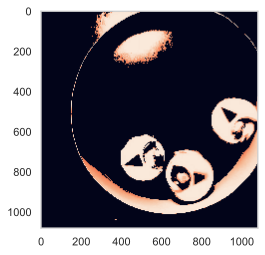

In [162]:
plt.rcParams["axes.grid"] = False
plt.imshow(thresh)

In [163]:
(contours, _) = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
shapes = []
vtg = 0
for contour in contours:
    if len(cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)) == 4:
        if 3500 >= cv2.contourArea(contour) >= 1000:
            vtg = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            shapes.append([contour, cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)])
    

In [171]:
def convert_to_triangle(vertexes: np.ndarray):
    min = [10005000, 0, 0]
    for i in range (0, len(vertexes)):
        for j in range (i+1, len(vertexes)):
            if euclidian_distance(vertexes[i][0], vertexes[j][0]) < min[0]:
                min = [euclidian_distance(vertexes[i][0], vertexes[j][0]), i, j]
    return np.delete(vertexes, min[2], 0)

In [172]:
np.delete(shapes[0][1], 2, 0)

array([[[759, 810]],

       [[811, 818]],

       [[765, 862]]], dtype=int32)

In [173]:
convert_to_triangle(shapes[0][1])

array([[[759, 810]],

       [[811, 818]],

       [[765, 862]]], dtype=int32)

In [174]:
for c in range (0, len(shapes)):
    cv2.drawContours(img,shapes[c], 0, (255,128,0),3)

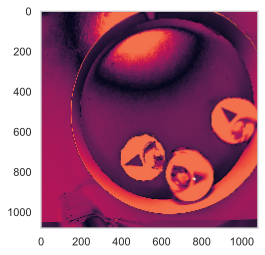

In [190]:
plt.imshow(img)

In [176]:
shapes[0][1] = convert_to_triangle(shapes[0][1])

In [178]:
def control_vertex(vertex_0, vertex_1, vertex_2):
    rho_1 =  euclidian_distance(vertex_0, vertex_1)
    rho_2 =  euclidian_distance(vertex_1, vertex_2)
    rho_3 =  euclidian_distance(vertex_0, vertex_2)

    if (rho_1 < rho_2 and rho_1 < rho_3):
        return (2, 0, 1)
    elif (rho_2 < rho_1 and rho_2 < rho_3):
        return (0, 1 , 2)
    else:
        return (1, 0 , 2)
    
def euclidian_distance(vertex_0: np.ndarray, vertex_1: np.ndarray):
    return ((vertex_0[0] - vertex_1[0])**2 + (vertex_0[1] - vertex_1[1])**2)**0.5

In [179]:
f = 0

In [180]:
#a = (int((shapes[2][1][vertexes[1]][0][0] + shapes[2][1][vertexes[2]][0][0])/2), int((shapes[2][1][vertexes[1]][0][1] + 
#                                             shapes[2][1][vertexes[2]][0][1])/2))
vertexes = control_vertex(shapes[f][1][0][0], shapes[f][1][1][0], shapes[f][1][2][0])
a = (int((shapes[f][1][vertexes[1]][0][0] + shapes[f][1][vertexes[2]][0][0])/2), int((shapes[f][1][vertexes[1]][0][1] + 
                                             shapes[f][1][vertexes[2]][0][1])/2))
a = (int((shapes[f][1][vertexes[1]][0][0] + shapes[f][1][vertexes[1]][0][0])/2), int((shapes[f][1][vertexes[1]][0][1] + 
                                             shapes[f][1][vertexes[1]][0][1])/2))

In [189]:

cv2.circle(img, a, 5, (255,128,0), 3)

array([[ 82,  72,  63, ..., 102, 104, 104],
       [ 77,  68,  60, ..., 102, 104, 104],
       [ 73,  65,  57, ..., 101, 103, 104],
       ...,
       [ 44,  42,  44, ...,  82,  84,  86],
       [ 44,  42,  44, ...,  86,  88,  88],
       [ 44,  42,  44, ...,  87,  90,  88]], dtype=uint8)

In [981]:
atan2(shapes[f][1][vertexes[0]][0][0] - a[0], shapes[f][1][vertexes[0]][0][1] - a[1])

1.2621454597180315

In [336]:
atan2(-1, -1555)*57

-179.03412531111832